/Applications/anaconda3/envs/py10/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/var/folders/rk/wm0jqkg16wgg146w5t5kkx340000gn/T/ipykernel_47864/2312765693.py:10: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data0_200/train_data_0_20.csv')  # Replace with your actual dataset file


Epoch [1/500], Train Loss: 1.1419, Test Loss: 3.3300
Epoch [11/500], Train Loss: 0.3257, Test Loss: 0.9034
Epoch [21/500], Train Loss: 0.1170, Test Loss: 0.4449
Epoch [31/500], Train Loss: 0.0907, Test Loss: 0.3055
Epoch [41/500], Train Loss: 0.0842, Test Loss: 0.2671
Epoch [51/500], Train Loss: 0.0827, Test Loss: 0.2386
Epoch [61/500], Train Loss: 0.0728, Test Loss: 0.2216
Epoch [71/500], Train Loss: 0.0758, Test Loss: 0.2131
Epoch [81/500], Train Loss: 0.0782, Test Loss: 0.2023
Epoch [91/500], Train Loss: 0.0777, Test Loss: 0.1941
Epoch [101/500], Train Loss: 0.0735, Test Loss: 0.1962
Epoch [111/500], Train Loss: 0.0686, Test Loss: 0.1908
Epoch [121/500], Train Loss: 0.0685, Test Loss: 0.1859
Epoch [131/500], Train Loss: 0.0722, Test Loss: 0.1838
Epoch [141/500], Train Loss: 0.0641, Test Loss: 0.1843
Epoch [151/500], Train Loss: 0.0682, Test Loss: 0.1828
Epoch [161/500], Train Loss: 0.0681, Test Loss: 0.1808
Early stopping at epoch 168


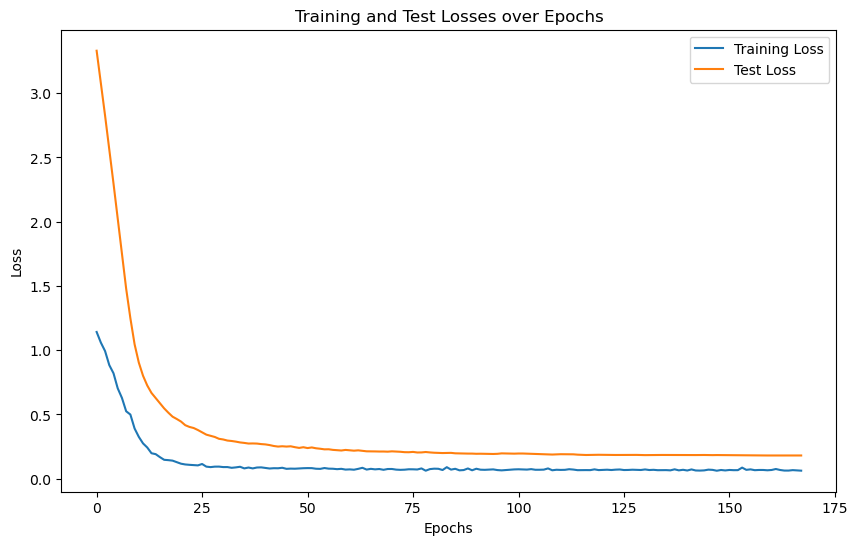

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# 1. Data Loading
data = pd.read_csv('data0_200/train_data_0_20.csv')  # Replace with your actual dataset file
data = data[data.tic == 'ARL']

# Split into train and test datasets
train, test = data.loc[data['date'] <= '2023-09-03'], data.loc[data['date'] > '2023-09-03']

# 2. Data Preprocessing
variables = ['close', 'volume', 'day', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 
             'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma', 'vix', 'turbulence']  # Only input features

# Remove NaNs if there are any missing values in the dataset
train = train.dropna()
test = test.dropna()

# Standardization of input features (variables)
scaler = StandardScaler()
train[variables] = scaler.fit_transform(train[variables])
test[variables] = scaler.transform(test[variables])

# Standardization of the target 'close' column separately (since close is the target)
scaler_target = StandardScaler()
train['close'] = scaler_target.fit_transform(train[['close']])
test['close'] = scaler_target.transform(test[['close']])

# Function to create sequences for input features (X) and target (y)
def create_sequences(data, target, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length]  # Input features sequence
        sequences.append(sequence)
        targets.append(target[i + sequence_length])  # Corresponding 'close' target
    return np.array(sequences), np.array(targets)

# Convert DataFrame to NumPy array for processing (only input features for X)
train_data = train[variables].values  # Only input features
test_data = test[variables].values  # Only input features

# Sequence length (e.g., 30 days)
sequence_length = 30

# Create sequences for training and testing, with target as 'close' price
X_train, y_train = create_sequences(train_data, train['close'].values, sequence_length)
X_test, y_test = create_sequences(test_data, test['close'].values, sequence_length)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add an extra dimension for correct shape
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)  # Add an extra dimension for correct shape

# Create DataLoader for mini-batch training
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Standard Two-Layer LSTM Model with Dropout
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)  # Dropout to reduce overfitting
        self.fc = nn.Linear(hidden_dim, 1)  # Fully connected layer for prediction

    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x)
        last_hidden_state = lstm_out[:, -1, :]  # Take the hidden state of the last time step
        last_hidden_state = self.dropout(last_hidden_state)  # Apply dropout
        output = self.fc(last_hidden_state)  # Get the final prediction
        return output

# Model parameters
input_dim = X_train.shape[2]  # number of features
hidden_dim = 32  # Reduce hidden units to 32 to avoid overfitting
num_layers = 1  # Using 1 layer for simplicity

# Initialize the model
model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers)

# 4. Define Loss Function, Optimizer, and Learning Rate Scheduler
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # L2 regularization
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)  # Reduce LR every 30 epochs

# 5. Early Stopping Parameters
patience = 10
best_test_loss = float('inf')
patience_counter = 0

# 6. Training the Model with Gradient Clipping and Early Stopping
num_epochs = 500
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0

    for X_batch, y_batch in train_loader:
        # Forward pass
        output = model(X_batch)
        loss = criterion(output, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Apply gradient clipping
        optimizer.step()

        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    # Evaluation on test data
    model.eval()
    with torch.no_grad():
        epoch_test_loss = 0
        for X_batch, y_batch in test_loader:
            test_output = model(X_batch)
            test_loss = criterion(test_output, y_batch)
            epoch_test_loss += test_loss.item()

        test_losses.append(epoch_test_loss / len(test_loader))

    # Adjust learning rate
    scheduler.step()

    # Early stopping check
    if test_losses[-1] < best_test_loss:
        best_test_loss = test_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')


# 7. Plotting the Training and Test Losses
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.title('Training and Test Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Reconstruction error threshold: 0.587981167435646


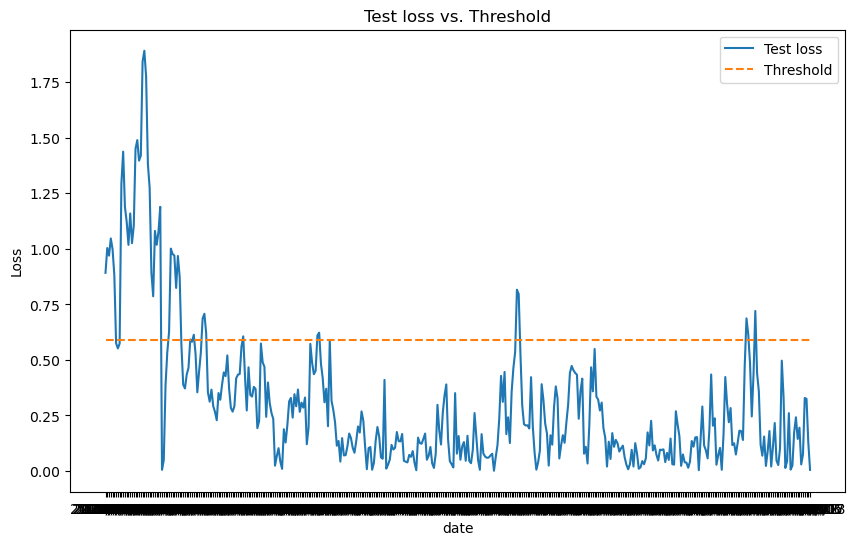

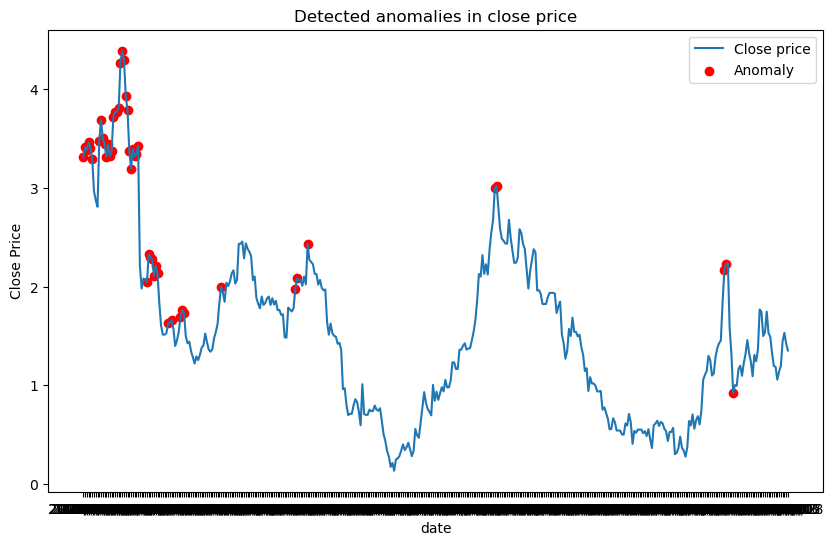

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Assuming the model is already trained, we are adding anomaly detection based on loss

# Set anomaly detection threshold based on the 90th percentile of training MAE loss
with torch.no_grad():
    X_train_pred = model(X_train_tensor)
    train_mae_loss = torch.mean(torch.abs(X_train_pred - y_train_tensor), dim=1).numpy()

threshold = np.percentile(train_mae_loss, 99)
print(f'Reconstruction error threshold: {threshold}')

# Test data predictions and anomaly detection
with torch.no_grad():
    X_test_pred = model(X_test_tensor)
    test_mae_loss = torch.mean(torch.abs(X_test_pred - y_test_tensor), dim=1).numpy()

# Create a DataFrame to hold the results
test_score_df = pd.DataFrame(test[sequence_length:]).reset_index(drop=True)  # Adjusted for the sequence length
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']

# Inverse transform the close prices back to their original scale
test_score_df['close'] = scaler_target.inverse_transform(test[sequence_length:]['close'].values.reshape(-1, 1))

# Plot test MAE loss and threshold
plt.figure(figsize=(10, 6))
plt.plot(test_score_df['date'], test_score_df['loss'], label='Test loss')
plt.plot(test_score_df['date'], test_score_df['threshold'], label='Threshold', linestyle='--')
plt.title('Test loss vs. Threshold')
plt.xlabel('date')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize anomalies on the actual close price
plt.figure(figsize=(10, 6))
plt.plot(test_score_df['date'], test_score_df['close'], label='Close price')
plt.scatter(test_score_df.loc[test_score_df['anomaly'], 'date'], 
            test_score_df.loc[test_score_df['anomaly'], 'close'], 
            color='red', label='Anomaly', marker='o')
plt.title('Detected anomalies in close price')
plt.xlabel('date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
